In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np 
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [8]:
data = pd.read_csv(r'D:\Week4\data\store.csv')
# Print the column names
print("Column names:", data.columns.tolist())
# Print initial DataFrame info to inspect types and missing values
print(data.info())
print(data.head())

# Create a date range
# Assuming there are 6 weeks of daily sales data; adjust as necessary
date_range = pd.date_range(start='2021-01-01', periods=len(data), freq='D')  # Adjust start date and frequency
data['date'] = date_range

Column names: ['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64

In [9]:
# Create a synthetic target variable if needed
np.random.seed(0)  # For reproducibility
data['sales'] = np.random.randint(100, 1000, size=len(data))  # Random sales figures

# Create a date range (if necessary)
date_range = pd.date_range(start='2021-01-01', periods=len(data), freq='D')  # Adjust as necessary
data['date'] = date_range

# Handle Missing Values
data.ffill(inplace=True)  # Forward fill for simplicity

# Convert Datetime Columns
data['date'] = pd.to_datetime(data['date'])

# Extracting Features
data['weekday'] = data['date'].dt.weekday
data['is_weekend'] = (data['weekday'] >= 5).astype(int)
data['is_beginning_of_month'] = data['date'].dt.day <= 7
data['is_mid_month'] = (data['date'].dt.day > 7) & (data['date'].dt.day <= 14)
data['is_end_of_month'] = data['date'].dt.day > 14

# Additional features
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['quarter'] = data['date'].dt.quarter
data['day_of_year'] = data['date'].dt.dayofyear
data['is_first_half_of_year'] = (data['month'] <= 6).astype(int)  # 1 if first half, 0 otherwise

# Convert categorical variables to numeric (if applicable)
data = pd.get_dummies(data, columns=['StoreType', 'Assortment'], drop_first=True)

# Scale the Data
features_to_scale = ['weekday', 'is_weekend', 
                     'is_beginning_of_month', 
                     'is_mid_month', 'is_end_of_month', 
                     'month', 'year', 'quarter', 'day_of_year', 
                     'is_first_half_of_year']

scaler = StandardScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

# Prepare the data for modeling
X = data.drop(columns=['sales'])  # The synthetic target variable
y = data['sales']


In [10]:
# Create a synthetic target variable if needed
np.random.seed(0)
data['sales'] = np.random.randint(100, 1000, size=len(data))

# Create a date range
date_range = pd.date_range(start='2021-01-01', periods=len(data), freq='D')
data['date'] = date_range

# Data preprocessing steps
data.ffill(inplace=True)  # Handle missing values
data['date'] = pd.to_datetime(data['date'])  # Convert to datetime
data['weekday'] = data['date'].dt.weekday
data['is_weekend'] = (data['weekday'] >= 5).astype(int)
data['is_beginning_of_month'] = data['date'].dt.day <= 7
data['is_mid_month'] = (data['date'].dt.day > 7) & (data['date'].dt.day <= 14)
data['is_end_of_month'] = data['date'].dt.day > 14
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['quarter'] = data['date'].dt.quarter
data['day_of_year'] = data['date'].dt.dayofyear
data['is_first_half_of_year'] = (data['month'] <= 6).astype(int)

# Drop the PromoInterval column
data.drop(columns=['PromoInterval'], inplace=True)

# Prepare the data for modeling
X = data.drop(columns=['sales', 'date'])  # Exclude non-numeric columns, including the original StoreType and Assortment
y = data['sales']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline for modeling
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Step for scaling
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))  # Random Forest model
])

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')


Mean Squared Error: 69500.67


In [11]:
# Define the model
rf = RandomForestRegressor(random_state=42)

# Set up the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

# Set up Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated MSE:", -grid_search.best_score_)

# Use the best model to make predictions
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error after tuning: {mse:.2f}')

Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validated MSE: 71804.70283003796
Mean Squared Error after tuning: 68452.19


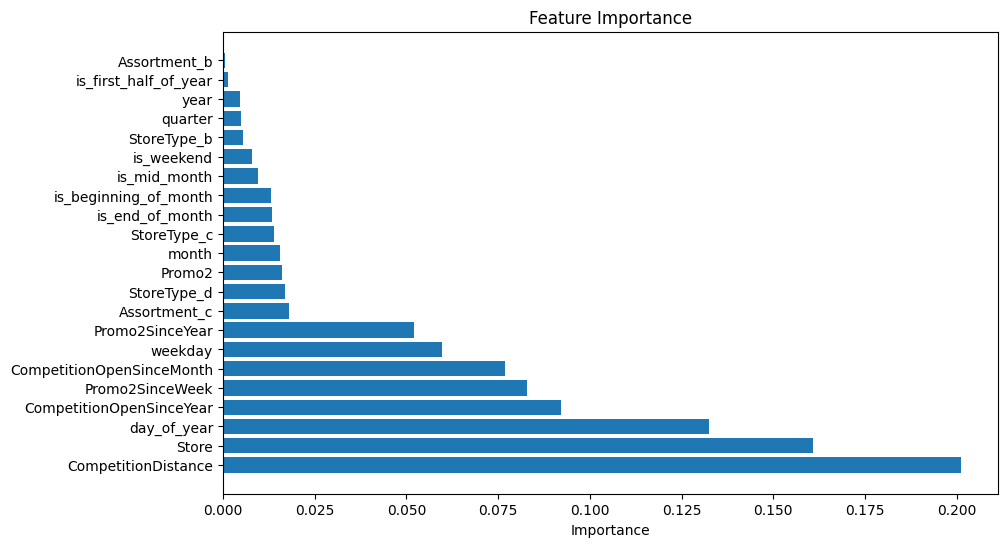

In [12]:
# Get feature importances
importances = best_rf.feature_importances_

# Create a DataFrame for visualization
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()